In [1]:
import mocet
import os
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import sys

sys.path.append('/DATA/publish/mocet/analysis/scripts')
from utils.base import get_minecraft_subjects, get_project_directory, get_configs

subject_pool = get_minecraft_subjects()
project_dir = get_project_directory()
configs = get_configs()

from numpy.polynomial.legendre import Legendre
from sklearn.linear_model import LinearRegression

def make_poly_regressors(n_samples, order=2):
    X = np.ones((n_samples, 0))
    for d in range(order):
        poly = Legendre.basis(d + 1)
        poly_trend = poly(np.linspace(-1, 1, n_samples))
        X = np.hstack((X, poly_trend[:, None]))
    return X

def polynomial_detrending(pupil_data, polynomial_order):
    X = make_poly_regressors(len(pupil_data), order=polynomial_order)
    dedrift_regressor = np.zeros((len(pupil_data), 2))
    for i in range(2):
        reg = LinearRegression(fit_intercept=False).fit(X, pupil_data[:, i])
        dedrift_regressor[:, i] = reg.predict(X)
    pupil_data = pupil_data[:, :2] - dedrift_regressor
    return pupil_data

calibration_onsets = configs['calibration_onsets']
calibration_points = configs['calibration_points']
interval = configs['interval']
task_duration = configs['task_duration']
task = configs['task']

calibration_offset_start = configs['calibration_offset_start']
calibration_offset_end = configs['calibration_offset_end']
calibration_threshold = configs['calibration_threshold']
px_per_deg = configs['px_per_deg']
avg_pupil_diameter_mm = configs['avg_pupil_diameter_mm']
calibration_coordinates = configs['calibration_coordinates']
calibration_order = configs['calibration_order']

valid_data = pickle.load(open('../../data/valid_data_list.pkl', 'rb'))

subjects = []
subjects_runs = {}
for key in list(valid_data.keys()):
    subjects.append(key[0])
    if not subjects_runs.keys().__contains__(key[0]):
        subjects_runs[key[0]] = 0
    subjects_runs[key[0]] += 1
subjects = list(set(subjects))
subjects.sort()

print(len(subjects), subjects)
print("average number of runs:", np.mean(list(subjects_runs.values())),
      "+-", np.std(list(subjects_runs.values())))

18 ['sub-003', 'sub-004', 'sub-005', 'sub-006', 'sub-008', 'sub-009', 'sub-010', 'sub-011', 'sub-015', 'sub-016', 'sub-018', 'sub-019', 'sub-020', 'sub-021', 'sub-022', 'sub-023', 'sub-024', 'sub-PBJ']
average number of runs: 7.388888888888889 +- 3.0393509703533175


In [2]:
from scipy import interpolate

correction_types = ['mocet', 'polynomial', 'linear', 'uncorrected']
resample_fs = np.logspace(np.log10(60), np.log10(1), 10)
resample_accuracy = {}
for correction in correction_types:
    resample_accuracy[correction] = {}
    for f, fs in enumerate(resample_fs):
        resample_accuracy[correction][fs] = []

for correction in correction_types:
    for f, fs in enumerate(resample_fs):
        print(correction, fs)
        for subject in subjects:
            subject_accuracy = []
            sessions = subject_pool[subject].keys()
            for session in sessions:
                runs = subject_pool[subject][session]
                root = f'{project_dir}/data/eyetracking/{subject}/{session}'
                for r in runs:
                    run = f'run-{r}'
                    np.random.seed(0)
                    key = (subject, session, task, run)
                    if key in valid_data.keys():
                        log_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_log.csv'
                        data_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_dat.txt'
                        confounds_fname = f'{root}/{subject}_{session}_{task}_{run}_desc-confounds_timeseries.tsv'
                        history_fname = f'{root}/{subject}_{session}_{task}_{run}_recording-eyetracking_physio_his.txt'
                        start, _, _ = mocet.utils.get_viewpoint_history(history_fname)

                        # log, data, confound, start
                        pupil_data, pupil_timestamps, pupil_confidence, _ = mocet.utils.clean_viewpoint_data(log_fname,
                                                                                                             data_fname,
                                                                                                             start=start,
                                                                                                             duration=task_duration)

                        resampled_timestamps = np.linspace(pupil_timestamps[0], pupil_timestamps[-1],
                                                           int(task_duration * fs))
                        resampled_pupil_data = np.zeros((len(resampled_timestamps), 2))
                        for i in range(2):  # x, y
                            f = interpolate.interp1d(pupil_timestamps, pupil_data[:, i])
                            resampled_pupil_data[:, i] = f(resampled_timestamps)

                        f = interpolate.interp1d(pupil_timestamps, pupil_confidence)
                        resampled_pupil_confidence = f(resampled_timestamps)

                        if correction == 'mocet':
                            resampled_pupil_data = mocet.apply_mocet(pupil_data=resampled_pupil_data,
                                                                     motion_params_fname=confounds_fname,
                                                                     pupil_confidence=resampled_pupil_confidence,
                                                                     large_motion_params=False,
                                                                     polynomial_order=3)
                        elif correction == 'polynomial':
                            resampled_pupil_data = polynomial_detrending(resampled_pupil_data, polynomial_order=3)
                        elif correction == 'linear':
                            resampled_pupil_data = polynomial_detrending(resampled_pupil_data, polynomial_order=1)
                        else:
                            pass

                        t_cal = 0
                        t_val = 1

                        offset = calibration_onsets[t_cal]
                        calibration_pupils = []
                        for i in np.arange(calibration_points[t_cal]):
                            calibration_offset_start = configs['calibration_offset_start']
                            calibration_offset_end = configs['calibration_offset_end']
                            while True:
                                start = (offset + i) * interval + calibration_offset_start
                                end = (offset + i + 1) * interval + calibration_offset_end
                                log_effective = np.logical_and(resampled_timestamps >= start * 1000,
                                                               resampled_timestamps < end * 1000)
                                if np.sum(log_effective) > 0:
                                    break
                                else:
                                    calibration_offset_start -= 0.05
                                    calibration_offset_end += 0.05
                            calibration_pupils.append([np.nanmean(resampled_pupil_data[log_effective, 0]),
                                                       np.nanmean(resampled_pupil_data[log_effective, 1])])
                        calibration_pupils = np.array(calibration_pupils)

                        repeat = True if calibration_points[t_cal] == 24 else False
                        calibrator = mocet.EyetrackingCalibration(calibration_coordinates=calibration_coordinates,
                                                                  calibration_order=calibration_order,
                                                                  repeat=repeat)
                        calibrator.fit(calibration_pupils[:, 0], calibration_pupils[:, 1])
                        gaze_coordinates = calibrator.transform(resampled_pupil_data)

                        t = t_val
                        MSE = []
                        offset = calibration_onsets[t]
                        for i in np.arange(calibration_points[t]):
                            ref_x = calibrator.calibration_coordinates[calibrator.calibration_order[i]][0]
                            ref_y = calibrator.calibration_coordinates[calibrator.calibration_order[i]][1]
                            calibration_offset_start = configs['calibration_offset_start']
                            calibration_offset_end = configs['calibration_offset_end']
                            while True:
                                start = (offset + i) * interval + calibration_offset_start
                                end = (offset + i + 1) * interval + calibration_offset_end
                                gaze_idx_start = np.min(np.where(resampled_timestamps >= start * 1000)[0])
                                gaze_idx_end = np.min(np.where(resampled_timestamps >= end * 1000)[0])
                                if (gaze_idx_end - gaze_idx_start) > 0:
                                    break
                                else:
                                    calibration_offset_start -= 0.05
                                    calibration_offset_end += 0.05
                            eye_closed = np.isnan(resampled_pupil_confidence[gaze_idx_start:gaze_idx_end])
                            if np.any(~eye_closed):
                                data_x = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 0][~eye_closed])
                                data_y = np.nanmean(gaze_coordinates[gaze_idx_start:gaze_idx_end, 1][~eye_closed])
                                MSE.append(np.sqrt((ref_x - data_x) ** 2 + (ref_y - data_y) ** 2))
                        validation_error = np.nanmean(MSE) / px_per_deg
                        subject_accuracy.append(validation_error)

            resample_accuracy[correction][fs].append(np.mean(subject_accuracy))

with open(f'resample_accuracy.pkl', 'wb') as f:
    pickle.dump(resample_accuracy, f)

mocet 60.0
mocet 38.06965045228559
mocet 24.154971425986794
mocet 15.326188647871062
mocet 9.724377409837311
mocet 6.170060814310145
mocet 3.9148676411688634
mocet 2.483960711104373
mocet 1.5760586001492372
mocet 1.0
polynomial 60.0
polynomial 38.06965045228559
polynomial 24.154971425986794
polynomial 15.326188647871062
polynomial 9.724377409837311
polynomial 6.170060814310145
polynomial 3.9148676411688634
polynomial 2.483960711104373
polynomial 1.5760586001492372
polynomial 1.0
linear 60.0
linear 38.06965045228559
linear 24.154971425986794
linear 15.326188647871062
linear 9.724377409837311
linear 6.170060814310145
linear 3.9148676411688634
linear 2.483960711104373
linear 1.5760586001492372
linear 1.0
uncorrected 60.0
uncorrected 38.06965045228559
uncorrected 24.154971425986794
uncorrected 15.326188647871062
uncorrected 9.724377409837311
uncorrected 6.170060814310145
uncorrected 3.9148676411688634
uncorrected 2.483960711104373
uncorrected 1.5760586001492372
uncorrected 1.0


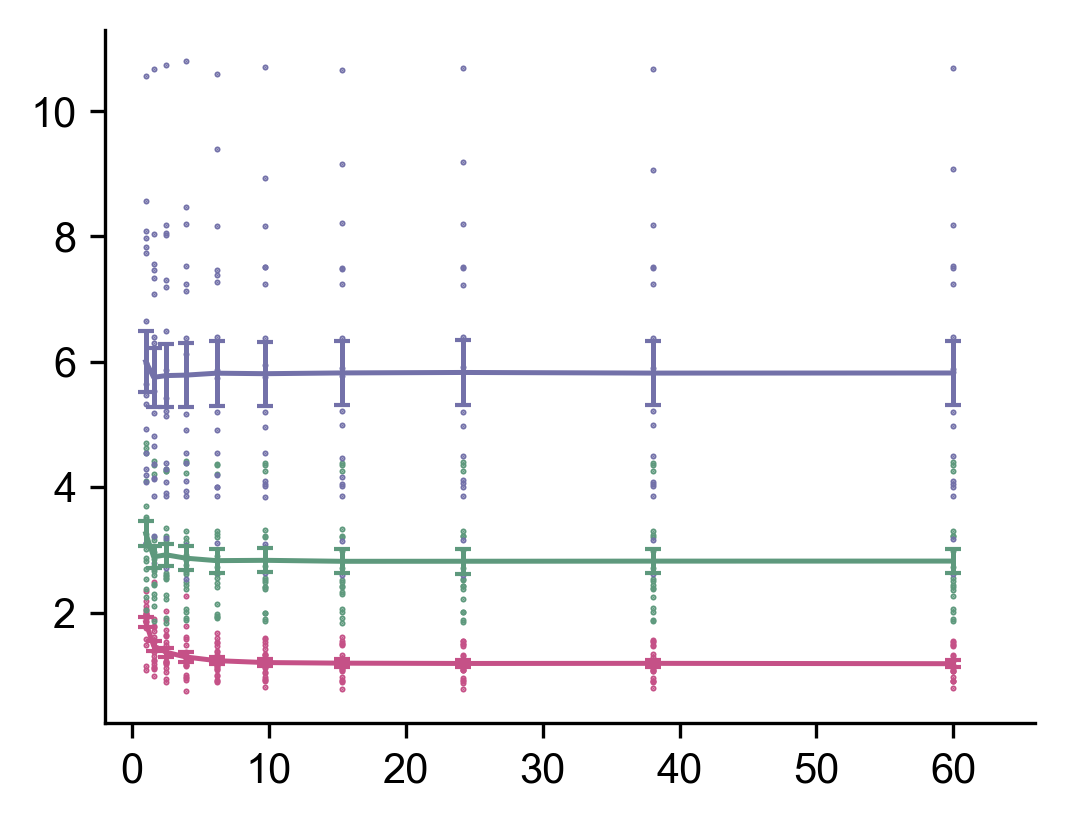

In [19]:
from scipy.stats import sem

plt.style.use('default')

color_list = ['#c55187', '#5e997d', '#7371a9', '#444444']
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=300, sharex=True)
for c, correction in enumerate(correction_types[:3]):
    ax.errorbar(resample_fs,
                [np.mean(resample_accuracy[correction][fs]) for fs in resample_fs],
                yerr=[sem(resample_accuracy[correction][fs]) for fs in resample_fs],
                capsize=2,
                c=color_list[c],
                lw=1.2,
                )
    for fs in resample_fs:
        ax.scatter(fs * np.ones(len(resample_accuracy[correction][fs])),
                   resample_accuracy[correction][fs],
                   s=0.2, c=color_list[c])

    ax.spines[['right', 'top']].set_visible(False)
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60])
    ax.set_xlim(None, 66)
    #ax.set_yticks([0, 2, 4, 6, 8])
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")

In [17]:
from scipy.stats import ttest_rel
for fs in resample_fs:
    print(ttest_rel(resample_accuracy['mocet'][fs], resample_accuracy['polynomial'][fs]))
    print(ttest_rel(resample_accuracy['mocet'][fs], resample_accuracy['linear'][fs]))
    print(ttest_rel(resample_accuracy['mocet'][fs], resample_accuracy['uncorrected'][fs]))

TtestResult(statistic=np.float64(-7.118744530794743), pvalue=np.float64(1.7212870194406536e-06), df=np.int64(17))
TtestResult(statistic=np.float64(-8.889207703520903), pvalue=np.float64(8.446252634470581e-08), df=np.int64(17))
TtestResult(statistic=np.float64(-7.03807711501419), pvalue=np.float64(1.9941883575455205e-06), df=np.int64(17))
TtestResult(statistic=np.float64(-7.07377090491895), pvalue=np.float64(1.8682657227246955e-06), df=np.int64(17))
TtestResult(statistic=np.float64(-8.904844321931533), pvalue=np.float64(8.238798585900274e-08), df=np.int64(17))
TtestResult(statistic=np.float64(-7.03265605645919), pvalue=np.float64(2.014072241934769e-06), df=np.int64(17))
TtestResult(statistic=np.float64(-7.046685573592756), pvalue=np.float64(1.9630321035350374e-06), df=np.int64(17))
TtestResult(statistic=np.float64(-8.887211492120906), pvalue=np.float64(8.473127852383279e-08), df=np.int64(17))
TtestResult(statistic=np.float64(-7.017087711984266), pvalue=np.float64(2.0723304545278982e-06)